### First of all, we import some usefull libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D
import time as time
from matplotlib import path
from matplotlib.path import Path
from tqdm import tqdm

We initializate the temporary counter and define next parameters.

In [2]:
t0 = time.perf_counter()
s = -25.
n = 6
#a = 41
a = 10

max_in_sum_1 = 50
max_in_sum_2 = 50 # Cambiar a 100.

mask = np.loadtxt('mask_boundary_SQUARE.dat')
_type_ = 'Complex'
_grid_ = 'Rectangular'

Definimos unha función para determinar puntos dentro e fóra da máscara e o seu raio.

In [3]:
c = np.arange(0, 10, 0.01)
c = np.delete(c, 0)

zeros = sc.special.jn_zeros(1, n + 5) / np.pi

def pass_to_dB(function):
    return 10 * np.log10(function / np.max(function))

def clear_around(function):
    #function[np.where(r > np.pi / 2)] = - 50
    function[np.where(function < - 50)] = - 50

def degrees(angle):
    return 180 * angle / np.pi

def radians(angle):
    return np.pi * angle / 180

def _ancho_(phi_rad_0):
    theta = 0
    
    for i in np.arange(1, 5): # Calculamos o ancho exacto a -0.50 dB
        step = 10 / 8**i
        temp = 1
        
        while temp > 0:
            theta += step
            u = np.sin(radians(theta)) * np.cos(phi_rad_0)
            v = np.sin(radians(theta)) * np.sin(phi_rad_0)
            temp = mask_path.contains_point((u, v)) * 1 # 1 se o contén, 0 se non.
        
        theta -= step
    return np.sin(radians(theta))

def track_radio_mask(radio_0, sin_theta_0, mask, phi_rad):
    sin_theta_vector = np.zeros(len(phi_rad))
    
    for i in range(len(phi_rad)):
        sin_theta_vector[i] = _ancho_(phi_rad[i])
    
    return radio_0 * sin_theta_0 / sin_theta_vector

Procedemos ao cálculos coa máscara.

In [4]:
mask_path = Path((mask))

radio_0 = 50 # Radio de 50 lambda.
sin_theta_0 = 0.04273

phi_rad = np.linspace(-np.pi, np.pi + 0.1, 3601)
radio_vector = track_radio_mask(radio_0, sin_theta_0, mask, phi_rad) # Creamos o vector radio.

Definimos as funcións $F(u, \phi)$

In [5]:
# Complexo.
u_complex = np.array([0.5967, 1.7837, 3.6420, 4.3039, 5.2119])
v_complex = np.array([0.5225, 0.5268, 0, 0, 0])

# Real.
u_real = np.array([1.0225, 3.0445, 5.4319, 6.1570, 7.1293])
v_real = np.array([1.1424, 1.0829, 0, 0, 0])

def _complex_(u, Phi):
    
    while np.abs(Phi) > np.pi:
        if Phi > np.pi:
            Phi -= 2 * np.pi
        else:
            Phi += 2 * np.pi
    
    m = int(1800 + round(10 * degrees(Phi)))
    u *= radio_vector[m] / radio_0
    h_1 = 1; h_2 = 1; h_f = 1
    
    for j in np.arange(0, n - 1):
        h_1 *= u_complex[j]**4 + v_complex[j]**4 + u**4 + 2 * u_complex[j]**2 * v_complex[j]**2 + 2 * u**2 * (v_complex[j]**2 - u_complex[j]**2)
        h_2 *= u_complex[j]**2 + v_complex[j]**2
        h_f *= 1 - (u / zeros[j])**2
        
    return (2 * sc.special.j1(np.pi * u) / (h_f * np.pi * u))**2 * h_1 / h_2**2

def _real_(u, Phi):
    
    while np.abs(Phi) > np.pi:
        if Phi > np.pi:
            Phi -= 2 * np.pi
        else:
            Phi += 2 * np.pi
    
    m = int(1800 + round(10 * degrees(Phi)))
    u *= radio_vector[m] / radio_0
    h_1 = 1; h_2 = 1; h_f = 1
    M = np.count_nonzero(v_real)
    
    for j in np.arange(0, M):
        h_1 *= u_real[j]**4 + v_real[j]**4 + u**4 + 2 * u_real[j]**2 * v_real[j]**2 + 2 * u**2 * (v_real[j]**2 - u_real[j]**2)
        h_2 *= u_real[j]**2 + v_real[j]**2
    
    for j in np.arange(M, n - 1):
        h_1 *= u_real[j]**2 - u**2
        h_2 *= u_real[j]**2
    
    for j in np.arange(0, n + M - 1):
        h_f *= 1 - (u / zeros[j])**2
        
    return ((2 * sc.special.j1(np.pi * u) * h_1) / (h_f * h_2 * np.pi * u))**2

if _type_ == 'Real':
    function_type = _real_
    _type_ = '_real_'
    
elif _type_ == 'Complex':
    function_type = _complex_
    _type_ = '_complex_'

In [3]:
np.arange(0, 5 - 1)

array([0, 1, 2, 3])

## Calculamos $F_k(u)$

In [6]:
def F_k(k, u):
    def integral_function(phi): return function_type(u, phi) * np.exp(- 1j * k * phi)
    def real_integral_function(phi): return np.real(integral_function(phi))
    def imaginary_integral_function(phi): return np.imag(integral_function(phi))

    real_integral = quad(real_integral_function, -np.pi, np.pi, epsabs = 1.49e-11, epsrel = 1.49e-11, limit = 100000)
    imag_integral = quad(imaginary_integral_function, -np.pi, np.pi, epsabs = 1.49e-11, epsrel = 1.49e-11, limit = 100000)
    sc.integrate.IntegrationWarning()
    return 0.5 * (real_integral[0] + 1j*imag_integral[0]) / np.pi

## Zeros de Bessel

In [7]:
rows = 2 * max_in_sum_2 + 1
columns = max_in_sum_1 + 1

Bessel_zeros = np.zeros((max_in_sum_2 + 1, columns))

for k in range(max_in_sum_2 + 1):
    Bessel_zeros[k, 1:max_in_sum_1 + 1] = sc.special.jn_zeros(k, max_in_sum_1) / np.pi

## Táboas de $F_n(p)$

In [8]:
Table_2 = True

if Table_2:
    aux = np.zeros((rows, columns), dtype = 'complex')
    
    for k in np.arange(- max_in_sum_2, max_in_sum_2 + 1):
        print('{:.1%}'.format((k + max_in_sum_2 + 1) / (2 * max_in_sum_2 + 1)))
        
        if k == 0:
            gamma_nm = Bessel_zeros[1, :]
        else:
            gamma_nm = Bessel_zeros[np.abs(k), :]
        
        for zero in range(columns):
            if gamma_nm[zero] in Bessel_zeros[1, :]:
                gamma_nm[zero] += 1e-10
            
            aux[k + max_in_sum_2, zero] = F_k(k, gamma_nm[zero])
    
    np.savetxt('Table_F_n' + _type_ + str(max_in_sum_1) + '_' + str(max_in_sum_2) + '.txt', aux)

1.0%


<ipython-input-6-b62885e085c0>:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  real_integral = quad(real_integral_function, -np.pi, np.pi, epsabs = 1.49e-11, epsrel = 1.49e-11, limit = 100000)
<ipython-input-6-b62885e085c0>:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  imag_integral = quad(imaginary_integral_function, -np.pi, np.pi, epsabs = 1.49e-11, epsrel = 1.49e-11, limit = 100000)
<ipython-input-6-b62885e085c0>:6: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  real_integral = quad(real_integral_function, -np.pi, np.pi, epsabs = 1.49e-11, epsrel = 1.49e-11, limit = 100000)
<ipython-input-6-b62885e085c0>:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  imag_integral = quad(

2.0%
3.0%
4.0%
5.0%
5.9%
6.9%
7.9%
8.9%
9.9%
10.9%
11.9%
12.9%
13.9%
14.9%
15.8%
16.8%
17.8%
18.8%
19.8%
20.8%
21.8%
22.8%
23.8%
24.8%
25.7%
26.7%
27.7%
28.7%
29.7%
30.7%
31.7%
32.7%
33.7%
34.7%
35.6%
36.6%
37.6%
38.6%
39.6%
40.6%
41.6%
42.6%
43.6%
44.6%
45.5%
46.5%
47.5%
48.5%
49.5%
50.5%
51.5%
52.5%
53.5%
54.5%
55.4%
56.4%
57.4%
58.4%
59.4%
60.4%
61.4%
62.4%
63.4%
64.4%
65.3%
66.3%
67.3%
68.3%
69.3%
70.3%
71.3%
72.3%
73.3%
74.3%
75.2%
76.2%
77.2%
78.2%
79.2%
80.2%
81.2%
82.2%
83.2%
84.2%
85.1%
86.1%
87.1%
88.1%
89.1%
90.1%
91.1%
92.1%
93.1%
94.1%
95.0%
96.0%
97.0%
98.0%
99.0%
100.0%


## Calculamos $g_n(p)$

In [9]:
if Table_2:
    F_k_loaded = aux
    
else:
    F_k_loaded = np.loadtxt('Aaron_Fn.dat', dtype = 'complex') # Cargamos as F_n de Aarón

def g_n(k, p): # Para todo n.
    aux = 0
    
    if k == 0:
        for m in np.arange(0, max_in_sum_1):
            gamma_1m = Bessel_zeros[1, m]
            aux += (F_k_loaded[max_in_sum_2, m] * sc.special.jv(0, gamma_1m * p)) / (sc.special.jv(0, gamma_1m * np.pi))**2 
    
    else:
        for m in np.arange(1, max_in_sum_1):
            gamma_nm = Bessel_zeros[np.abs(k), m]
            aux -= (F_k_loaded[k + max_in_sum_2, m] * sc.special.jv(k, gamma_nm * p)) / (sc.special.jv(k - 1, gamma_nm * np.pi) * sc.special.jv(k + 1, gamma_nm * np.pi))
        
    return 2 * aux / np.pi**2

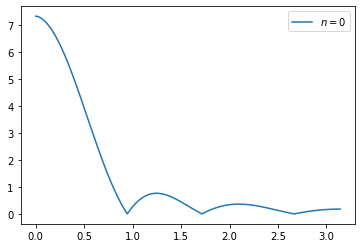

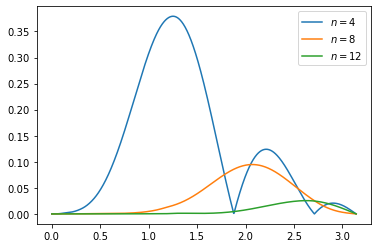

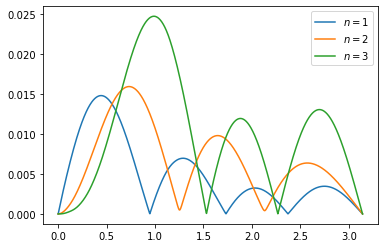

In [10]:
d = np.linspace(0, np.pi, 1000, endpoint = True)

plt.plot(d, np.abs(g_n(0, d)), label = u'$n = %.f$' %0)
plt.legend(loc = 'best')

plt.show()

for k in [4, 8, 12]:
    plt.plot(d, np.abs(g_n(k, d)), label = u'$n = %.f$' %k)
    plt.legend(loc = 'best')

plt.show()

for k in [1, 2, 3]:
    plt.plot(d, np.abs(g_n(k, d)), label = u'$n = %.f$' %k)
    plt.legend(loc = 'best')

plt.show()

## Calculamos $K_n(\rho)$

In [11]:
def K_n(k, p):
    return g_n(k, np.pi * p / a) * np.pi / (2 * a**2 * (1j)**k)

## Táboas de $K_n(\rho)$

In [12]:
Table_3 = True

radius_length = int((a + 0.5) / 0.01) + 1
radius = np.flip(np.linspace(a, 0, radius_length, endpoint = False))

if Table_3:
    _aux_ = np.zeros((2 * max_in_sum_2 + 1, radius_length), dtype = 'complex')

    for k in tqdm(np.arange(-max_in_sum_2, max_in_sum_2 + 1)):
        for j in range(radius_length):
            _aux_[k + max_in_sum_2, j] = K_n(k, radius[j])

    np.savetxt('Table_K_n' + _type_ + str(max_in_sum_2) + '_a_' + str(a) + '.txt', _aux_)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:44<00:00,  1.04s/it]


## Calculamos $K(\rho, \beta)$

In [13]:
if Table_3:
    K_n_loaded = _aux_
    
else:
    K_n_loaded = np.loadtxt('Table_K_n_complex_50_a_41.txt', dtype = 'complex')

def find_nearest(array, value): # It returns the position.
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return int(idx)

def K_rho_beta(p, beta): # K_6_45
    _aux_ = 0 + 1j*0
    
    for k in np.arange(- max_in_sum_2, max_in_sum_2 + 1):
        idx = find_nearest(radius, p)
        _aux_ += K_n_loaded[k + max_in_sum_2, idx] * np.exp(1j * k * beta)
    
    return _aux_

## Discretizamos

A continuación discretizamos a antena para calcular as excitacións usando o método de valor media dos vértices do cadrado.

In [14]:
spacing = 0.5 # Cambiar a 0.1.
half_spacing = 0.5 * spacing
I_mn = []
I_x = []
I_y = []

sign_x = np.array([1, 1, -1, -1])
sign_y = np.array([1, -1, 1, -1])

if _grid_ == 'Rectangular':
    limit = (np.int(a / spacing) + 0.5) * spacing
    
    for y in tqdm(np.arange(- limit, limit + 1, spacing)):        
        for x in np.arange(- limit, limit + 1, spacing):
            r_ij = np.sqrt(x**2 + y**2)
            beta_ij = np.arctan2(y, x)
            m = int(1800 + round(10 * degrees(beta_ij)))
            
            if r_ij <= radio_vector[m]:
                aux = 0 + 1j*0
                
                for i in range(4):
                    new_x = x + sign_x[i] * half_spacing
                    new_y = y + sign_y[i] * half_spacing
                    
                    r_ij = np.sqrt(new_x**2 + new_y**2)
                    beta_ij = np.arctan2(new_y, new_x)
                    aux += K_rho_beta(r_ij, beta_ij)
                
                aux /= 4
                I_mn.append(aux)
                I_x.append(x)
                I_y.append(y)

elif _grid_ == 'Circular':
    N_aros = np.int(a / spacing)
    
    for i in tqdm(range(N_aros)):
        r_ij = (i + 0.5) * spacing
        N_elementos_aro = np.int(2 * np.pi * r_ij / spacing)
        
        for j in range(N_elementos_aro):
            beta_ij = j * 2 * np.pi / N_elementos_aro
            aux = K_rho_beta(r_ij, beta_ij)
            I_mn.append(aux)
            I_x.append(r_ij * np.cos(beta_ij))
            I_y.append(r_ij * np.sin(beta_ij))

I_mn /= np.max(I_mn)

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:08<00:00,  4.79it/s]


## Rango dinámico

In [15]:
def dynamic_range(array):
    array = np.abs(array)
    return np.max(array) / np.min(array)

print('O rango dinámico é de: ', dynamic_range(I_mn))

# 22055.465605717578
# 11435.399472003062

O rango dinámico é de:  2758.5753198836837


## Calculamos $F(\theta, \phi)$

In [16]:
def F_theta_phi(Theta, Phi):
    aux_2 = 0 + 1j*0
    
    for k in range(len(I_mn)):
        aux = np.sin(Theta) * (I_x[k] * np.cos(Phi) + I_y[k] * np.sin(Phi))
        aux_2 += I_mn[k] * np.exp(1j * 2 * np.pi * aux)
        
    return aux_2

In [17]:
x = np.arange(- np.pi / 2, np.pi / 2, 0.01); x = np.delete(x, np.where(x == 0))
X, Y = np.meshgrid(x, x)

X_plot = np.sin(X)
Y_plot = np.sin(Y)

N = len(x)
N_square = N * N

theta = np.sqrt(X**2 + Y**2)
phi = np.arctan2(Y, X)

Theta = np.reshape(theta, (N_square))
Phi = np.reshape(phi, (N_square))

F_plot = np.abs(F_theta_phi(Theta, Phi))
F_plot = 2 * pass_to_dB(F_plot)
clear_around(F_plot)

F_plot = np.reshape(F_plot, (N, N))
np.savetxt('Data' + _type_ + 'F_theta_phi.txt', F_plot)

x = np.linspace(-np.pi / 2, np.pi / 2, N)
X_plot, Y_plot = np.meshgrid(x, x)

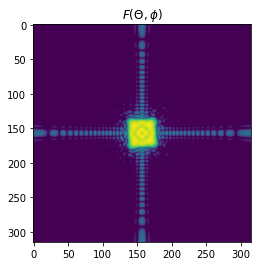

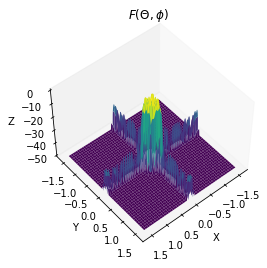

In [18]:
fig = plt.figure(1)
plt.imshow(F_plot)
plt.title('$F(\Theta, \phi)$')
plt.savefig('Horizontal' + _type_ + 'F_theta_phi.png', dpi = 300)

fig = plt.figure(2)
ax = plt.axes(projection = '3d')
ax.plot_surface(X_plot, Y_plot, F_plot, cmap = 'viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.grid(False)
ax.set_visible(True)
ax.set_zlim(-50, 0)
plt.title('$F(\Theta, \phi)$')
plt.savefig('3D' + _type_ + 'F_theta_phi.png', dpi = 300)
ax.view_init(50, 50)

In [19]:
print('Total execution time is:', np.round(time.perf_counter() - t0, 2), 's')

Total execution time is: 263315.19 s
